<a href="https://colab.research.google.com/github/tapickell/ml_python/blob/main/CatsNDogs_TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats and Dogs TF/Keras with GPU


## Setup and testing the GPU



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

2024-09-06 18:30:31.926119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 18:30:31.937422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 18:30:31.940716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 18:30:31.949944: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 18:30:32.473929: W tensorflow/compiler/tf2

Found GPU at: /device:GPU:0


I0000 00:00:1725665433.789492  111822 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725665433.822249  111822 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725665433.829833  111822 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725665433.931533  111822 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Data Setup


In [2]:
os.listdir()

['files',
 'cats_n_dogs_with_GPU.ipynb',
 '.ipynb_checkpoints',
 'TensorFlow_with_GPU-Copy1.ipynb',
 '.git',
 'README.md']

In [3]:
# prompt: write a function given a list of file paths return the number of files that conatin 'dog' and the number of files that contain 'cat'

def count_cats_and_dogs(file_paths):
  """
  Given a list of file paths, return the number of files that contain 'dog' and the number of files that contain 'cat'.

  Args:
    file_paths: A list of file paths.

  Returns:
    A tuple containing the number of dog files and the number of cat files.
  """
  dog_count = 0
  cat_count = 0
  for file_path in file_paths:
    if 'dog' in file_path:
      dog_count += 1
    elif 'cat' in file_path:
      cat_count += 1
  return  cat_count, dog_count


In [4]:
# prompt: create a list of file paths from the files in 'files/train/' shuffle the list and then split the list 1000 and assign that to test_paths and train_paths

import os
import random

# Get a list of file paths
train_path = glob.glob('files/train/*')
print(len(train_path))

# Shuffle the list
random.shuffle(train_path)

# Split the list
testing_paths = train_path[:1000]
train_paths = train_path[1000:]
print(len(testing_paths))
print(len(train_paths))
# Split for val paths
test_paths = testing_paths[:750]
val_paths = testing_paths[750:]
print(len(test_paths))
print(len(val_paths))
# Count the number of cats and dogs in each list
for path in [test_paths, train_paths, val_paths]:
  print(count_cats_and_dogs(path))

25000
1000
24000
750
250
(387, 363)
(11985, 12015)
(128, 122)


In [10]:
# prompt: write a function that given an array of file paths will create a dataframe from them and then use flow_from_dataframe

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_dataframe_and_flow(file_paths, shuffle=True, batch_size=32, target_size=(224, 224), class_mode='categorical'):
  """
  Creates a dataframe from file paths and uses flow_from_dataframe to generate batches of images.

  Args:
    file_paths: A list of file paths.
    batch_size: The batch size for the image generator.
    target_size: The target size for the images.
    class_mode: The class mode for the image generator.

  Returns:
    A tuple containing the dataframe and the image generator.
  """
  # Create a dataframe from the file paths
  df = pd.DataFrame({'filename': file_paths})
  df['class'] = df['filename'].apply(lambda x: 'dog' if 'dog' in x else 'cat')

  # Create an ImageDataGenerator
  datagen = ImageDataGenerator(rescale=1./255)

  # Use flow_from_dataframe to generate batches of images
  train_generator = datagen.flow_from_dataframe(
      dataframe=df,
      directory=None,
      x_col='filename',
      y_col='class',
      target_size=target_size,
      class_mode=class_mode,
      batch_size=batch_size,
      shuffle=shuffle
  )

  return df, train_generator



In [11]:
# prompt: map over [train_paths, test_paths, val_paths] using the create_data_frame_and_flow functon

# Map over [train_paths, test_paths, val_paths] using the create_data_frame_and_flow function
train_df, train_generator = create_dataframe_and_flow(train_paths)
test_df, test_generator = create_dataframe_and_flow(test_paths, shuffle=False)
val_df, val_generator = create_dataframe_and_flow(val_paths)


Found 24000 validated image filenames belonging to 2 classes.
Found 750 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


In [15]:
# prompt: I need a model that is sequential with canv2d relu activation, batch norm, max pool (2, 2) strides=2, conv2d relu activation, batch norm, max pool (2, 2) strides=2, conv2d relu activation,  max pool (2, 2) strides=2, flatten, dense 128 activation relu, dropout rate=0.5, dense 2 activation sigmoid

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    Dense(units=2, activation='softmax')
])


/home/tapickell/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,074 (49.36 MB)

 Trainable params: 12,938,882 (49.36 MB)

 Non-trainable params: 192 (768.00 B)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=train_generator, validation_data=val_generator, epochs=15, verbose=1)

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8297 - loss: 0.3671 - val_accuracy: 0.8000 - val_loss: 0.3969
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8429 - loss: 0.3364 - val_accuracy: 0.8440 - val_loss: 0.3704
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8553 - loss: 0.3058 - val_accuracy: 0.8400 - val_loss: 0.3695
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8655 - loss: 0.2794 - val_accuracy: 0.8280 - val_loss: 0.4321
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8780 - loss: 0.2563 - val_accuracy: 0.8520 - val_loss: 0.3887
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8882 - loss: 0.2293 - val_accuracy: 0.8480 - val_loss: 0.3680
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9069 - loss: 0.1936 - val_accuracy: 0.8160 - val_loss: 0.4748
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9068 - loss: 0.1890 - 

In [20]:
predictions = model.predict(x=test_generator, verbose=0)

/home/tapickell/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [21]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [23]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

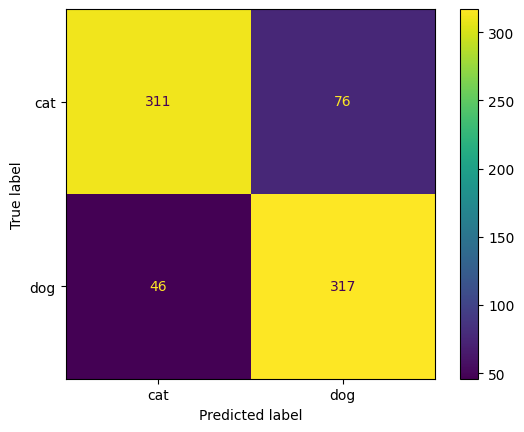

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot
cm_plot_labels = ['cat', 'dog']
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
plot.plot()

In [ ]:
import timeit

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900



I0000 00:00:1725627354.992403   89902 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725627354.993567   89902 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725627354.994455   89902 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725627354.995370   89902 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6627281159962877
GPU (s):
0.041002576996106654
GPU speedup over CPU: 16x
